* 2018-12-19 @Huang: based on Italy's "variables_derivation"

In [4]:
# impirt important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None  # show all columns

In [5]:
# read data
airline_data = pd.read_csv('../../data/dataset/airline.csv')
# cache_map_data = pd.read_csv('../../data/dataset/cache_map.csv')
group_data = pd.read_csv('../../data/dataset/group.csv')
order_data = pd.read_csv('../../data/dataset/order.csv')
day_schedule_data = pd.read_csv('../../data/dataset/day_schedule.csv')

#
column_names = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 
              'Altitude', 'Timezone', 'DST', 'TZ', 'Type','Source']
df_airport = pd.read_csv('../../data/airport.csv', names=column_names) #ref: https://openflights.org/data.html#airport

# test and train data
train_data = pd.read_csv('../../data/training-set.csv')
test_data = pd.read_csv('../../data/testing-set.csv')

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 處理訂單變數

In [6]:
order_data['order_date_dt'] = pd.to_datetime(order_data.order_date, format='%d-%b-%y') # ref: http://strftime.org/
order_data['order_year'] = order_data.order_date_dt.dt.year
order_data['order_month'] = order_data.order_date_dt.dt.month
order_data['order_day'] = order_data.order_date_dt.dt.day
order_data['order_dayofyear'] = order_data.order_date_dt.dt.dayofyear
order_data['order_weekday'] = order_data.order_date_dt.dt.dayofweek # 0=Mon, 6=Sun
order_data['unit']=order_data.unit.str.replace('unit_value_', '').astype(int)
order_data['source_1']=order_data.source_1.str.replace('src1_value_', '')
order_data['source_2']=order_data.source_2.str.replace('src2_value_', '')

### 處理group變數

In [7]:
group_data['sub_line'] = group_data.sub_line.str.replace('subline_value_','')
group_data['area'] = group_data.area.str.replace('area_value_','')
group_data['begin_date_dt'] = pd.to_datetime(group_data.begin_date, format='%d-%b-%y')
group_data['begin_year'] = group_data.begin_date_dt.dt.year
group_data['begin_month'] = group_data.begin_date_dt.dt.month
group_data['begin_day'] = group_data.begin_date_dt.dt.day
group_data['begin_dayofyear'] = group_data.begin_date_dt.dt.dayofyear
group_data['begin_weekday'] = group_data.begin_date_dt.dt.dayofweek # 0=Mon, 6=Sun
group_data['end_date_dt'] = group_data.begin_date_dt + group_data['days'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))
group_data['end_year'] = group_data.end_date_dt.dt.year
group_data['end_month'] = group_data.end_date_dt.dt.month
group_data['end_day'] = group_data.end_date_dt.dt.day
group_data['end_dayofyear'] = group_data.end_date_dt.dt.dayofyear
group_data['end_weekday'] = group_data.end_date_dt.dt.dayofweek # 0=Mon, 6=Sun

### 處理航班變數

In [8]:
#
airline_data['dst_airport'] = airline_data.dst_airport.str.replace('([A-Z]+) ([^A-Z]+)','\\1')
airline_data['src_airport'] = airline_data.src_airport.str.replace('([A-Z]+) ([^A-Z]+)','\\1')
airline_data['go_back'] = airline_data.go_back.str.replace('去程', 'go')
airline_data['go_back'] = airline_data.go_back.str.replace('回程', 'back')

# unify time, compute the travel time for each routes
airline_data['src_IATA'] = airline_data.src_airport.str.replace('([A-Z]+) ([^A-Z])+', '\\1')
airline_data['dst_IATA'] = airline_data.dst_airport.str.replace('([A-Z]+) ([^A-Z])+', '\\1')
tmp = pd.merge(airline_data, df_airport[['IATA','TZ']], left_on='src_IATA', right_on='IATA', how='left')
airline_data = tmp.rename(index=str, columns={'TZ':'src_TZ'}).drop(['IATA'], axis=1)
tmp = pd.merge(airline_data, df_airport[['IATA','TZ']], left_on='dst_IATA', right_on='IATA', how='left')
airline_data = tmp.rename(index=str, columns={'TZ':'dst_TZ'}).drop(['IATA'], axis=1)
airline_data['fly_time'] = pd.to_datetime(airline_data.fly_time, format='%Y/%m/%d %H:%M')
airline_data['arrive_time'] = pd.to_datetime(airline_data.arrive_time, format='%Y/%m/%d %H:%M')

def src_time_utc(x):
    try: 
        res = x['fly_time'].tz_localize(x['src_TZ']).tz_convert('UTC')
    except:
        res = None # 因為有些機場沒有抓到對應time-zone (可後續用手動補)
    return res

def dst_time_utc(x):
    try:
        res = x['arrive_time'].tz_localize(x['dst_TZ']).tz_convert('UTC')
    except:
        res = None
    return res

airline_data['arrive_time_utc'] = airline_data.apply(dst_time_utc, axis=1)
airline_data['fly_time_utc'] = airline_data.apply(src_time_utc, axis=1)
airline_data['traval_time'] = airline_data['arrive_time_utc'] - airline_data['fly_time_utc']

# derive number of routes for each group
go_route_num=airline_data[airline_data['go_back']=='go'].groupby('group_id')['dst_airport'].nunique()
back_route_num=airline_data[airline_data['go_back']=='back'].groupby('group_id')['dst_airport'].nunique()
df_route_num = pd.merge(go_route_num.to_frame('go_route_num'), back_route_num.to_frame('back_route_num'), left_index=True, right_index=True,how='outer')

# derive total travel time for each group
def mean(x):
    return x.sum()/x.count()

#
tmp=airline_data[airline_data.go_back=='go'].groupby(['group_id','dst_IATA'])['traval_time'].apply(mean)
#print(tmp.head())
go_time=tmp.to_frame().groupby(['group_id'])['traval_time'].sum()

#
tmp=airline_data[airline_data.go_back=='back'].groupby(['group_id','dst_IATA'])['traval_time'].apply(mean)
#print(tmp.head())
back_time=tmp.to_frame().groupby(['group_id'])['traval_time'].sum()

#
df_total_travel_time = pd.merge(go_time.to_frame('go_time'), back_time.to_frame('back_time'), left_index=True, right_index=True,how='outer')

In [9]:
# merge following two df with order_id on group_id 
print(df_total_travel_time.head())
print(df_route_num.head())

                                  go_time back_time
group_id                                           
00018d44e062e3db9dc0460a5c78f0ee 04:25:00  04:50:00
000858b64a52e724cd008bbfe2fc8cdd 02:15:00  02:35:00
000a91291573c4b8b44300de8136b86b 03:15:00  03:00:00
000d1cccbb593a8210840a43457aa5e2 02:25:00  02:20:00
0012d75d4bfe483a414b09b50b548f58 02:30:00  03:00:00
                                  go_route_num  back_route_num
group_id                                                      
00018d44e062e3db9dc0460a5c78f0ee           1.0             1.0
000858b64a52e724cd008bbfe2fc8cdd           1.0             1.0
000a91291573c4b8b44300de8136b86b           1.0             1.0
000d1cccbb593a8210840a43457aa5e2           1.0             1.0
0012d75d4bfe483a414b09b50b548f58           1.0             1.0


In [10]:
df_route_num.describe()

,go_route_num,back_route_num
count,48795.000000,48755.000000
mean,1.069905,1.067501
std,0.275391,0.268732
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,5.000000,4.000000


In [11]:
df_total_travel_time.describe() 

,go_time,back_time
count,48795,48755
mean,0 days 05:11:58.263756,0 days 05:02:34.065429
std,1 days 15:56:56.208220,0 days 04:03:28.856158
min,-1 days +08:55:00,-1 days +02:40:00
25%,0 days 02:30:00,0 days 02:40:00
50%,0 days 03:10:00,0 days 03:20:00
75%,0 days 04:35:00,0 days 04:50:00
max,365 days 17:40:00,1 days 15:25:00


In [12]:
tmp = airline_data[airline_data['go_back']=='go'].sort_values(by='fly_time')
df_airline_fly_time = tmp.groupby('group_id').first().reset_index()[['group_id', 'fly_time']]

> need to fix the cross year trip

In [13]:
tmp = pd.merge(order_data, df_total_travel_time.reset_index(), on='group_id', how='left')
tmp = pd.merge(tmp, df_route_num.reset_index(), on='group_id', how='left')
tmp = pd.merge(tmp, df_airline_fly_time, on='group_id', how='left')
df_predictors = pd.merge(tmp, group_data.drop(['product_name','promotion_prog'], axis=1), on='group_id', how='left').drop('order_date', axis=1)
df_predictors['date_diff_order_begin'] = df_predictors.fly_time - df_predictors.order_date_dt  

In [14]:
df_predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396915 entries, 0 to 396914
Data columns (total 35 columns):
order_id                 396915 non-null object
group_id                 396915 non-null object
source_1                 396915 non-null object
source_2                 396915 non-null object
unit                     396915 non-null int64
people_amount            396915 non-null int64
order_date_dt            396915 non-null datetime64[ns]
order_year               396915 non-null int64
order_month              396915 non-null int64
order_day                396915 non-null int64
order_dayofyear          396915 non-null int64
order_weekday            396915 non-null int64
go_time                  134507 non-null timedelta64[ns]
back_time                134523 non-null timedelta64[ns]
go_route_num             134507 non-null float64
back_route_num           134523 non-null float64
fly_time                 134507 non-null datetime64[ns]
sub_line                 134771 non-null obj

In [15]:
df_predictors.head()

,order_id,group_id,source_1,source_2,unit,people_amount,order_date_dt,order_year,order_month,order_day,order_dayofyear,order_weekday,go_time,back_time,go_route_num,back_route_num,fly_time,sub_line,area,days,begin_date,price,begin_date_dt,begin_year,begin_month,begin_day,begin_dayofyear,begin_weekday,end_date_dt,end_year,end_month,end_day,end_dayofyear,end_weekday,date_diff_order_begin
0,136100,63695,1,1,1,2,2017-01-05,2017,1,5,5,3,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
1,140370,63695,1,1,2,1,2016-11-09,2016,11,9,314,2,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
2,211009,63695,1,1,3,2,2017-01-20,2017,1,20,20,4,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
3,41571,53481,1,1,4,4,2017-03-14,2017,3,14,73,1,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
4,64125,53481,2,1,5,1,2017-03-27,2017,3,27,86,0,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT


> date_diff_order_begin 可能要trim掉太大的值，奇怪的數值和跨年有關

In [16]:
# 把時間轉單位轉成總共幾分
df_predictors.go_time = df_predictors.go_time.apply(lambda x: x.total_seconds()/60) 
df_predictors.back_time = df_predictors.back_time.apply(lambda x: x.total_seconds()/60) 
df_predictors.date_diff_order_begin = df_predictors.date_diff_order_begin.apply(lambda x: x.total_seconds()/60) 

In [17]:
df_predictors = df_predictors.drop(['order_date_dt','begin_date_dt','end_date_dt'], axis=1)

### check and separate the final dataset

In [18]:
df_predictors.shape

(396915, 32)

In [19]:
train_data['order_id'] = train_data['order_id'].astype(str)
df_predictors['order_id'] = df_predictors['order_id'].astype(str)
df_predictors['fly_time'] = df_predictors['fly_time'].astype(int)  ## TODO:  int is good ?????????????????????????

# seperate into train and test features
train_features = pd.merge(df_predictors, train_data, on='order_id', how='inner') 
test_features = pd.merge(df_predictors, test_data, on='order_id', how='inner')

In [18]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297020 entries, 0 to 297019
Data columns (total 33 columns):
order_id                 297020 non-null object
group_id                 297020 non-null object
source_1                 297020 non-null object
source_2                 297020 non-null object
unit                     297020 non-null int64
people_amount            297020 non-null int64
order_year               297020 non-null int64
order_month              297020 non-null int64
order_day                297020 non-null int64
order_dayofyear          297020 non-null int64
order_weekday            297020 non-null int64
go_time                  34771 non-null float64
back_time                34771 non-null float64
go_route_num             34771 non-null float64
back_route_num           34771 non-null float64
fly_time                 297020 non-null int64
sub_line                 34876 non-null object
area                     34876 non-null object
days                     34876 non-

In [19]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99895 entries, 0 to 99894
Data columns (total 33 columns):
order_id                 99895 non-null object
group_id                 99895 non-null object
source_1                 99895 non-null object
source_2                 99895 non-null object
unit                     99895 non-null int64
people_amount            99895 non-null int64
order_year               99895 non-null int64
order_month              99895 non-null int64
order_day                99895 non-null int64
order_dayofyear          99895 non-null int64
order_weekday            99895 non-null int64
go_time                  99736 non-null float64
back_time                99752 non-null float64
go_route_num             99736 non-null float64
back_route_num           99752 non-null float64
fly_time                 99895 non-null int64
sub_line                 99895 non-null object
area                     99895 non-null object
days                     99895 non-null float64
b

In [20]:
train_features = train_features.dropna()  # TODO:  try to save more data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

train_features_y = train_features['deal_or_not']
train_features_X = train_features.drop(['order_id', 'group_id', 'begin_date', 'deal_or_not'], axis=1)
# TODO: make dummy variavbles!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [21]:
train_features_X.head(10)

,source_1,source_2,unit,people_amount,order_year,order_month,order_day,order_dayofyear,order_weekday,go_time,back_time,go_route_num,back_route_num,fly_time,sub_line,area,days,price,begin_year,begin_month,begin_day,begin_dayofyear,begin_weekday,end_year,end_month,end_day,end_dayofyear,end_weekday,date_diff_order_begin
262144,2,3,3,5,2017,6,13,164,1,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,41345.0
262145,2,1,6,2,2017,6,28,179,2,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,19745.0
262146,2,3,6,2,2017,7,6,187,3,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,8225.0
262147,1,1,22,5,2017,6,9,160,4,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,47105.0
262148,1,1,41,4,2017,6,10,161,5,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,45665.0
262149,2,3,6,6,2017,6,12,163,0,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,42785.0
262150,2,3,16,10,2017,6,26,177,0,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,22625.0
262151,2,1,6,4,2017,6,30,181,4,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,16865.0
262152,2,1,6,2,2017,7,3,184,0,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,12545.0
262153,2,1,6,1,2017,6,13,164,1,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,41345.0


In [22]:
train_features_y.value_counts()

0    28269
1     6502
Name: deal_or_not, dtype: int64

In [23]:
# 題外話 check 'group_id' == '63695'
airline_data[airline_data['group_id'] == '63695']

,group_id,go_back,fly_time,src_airport,arrive_time,dst_airport,src_IATA,dst_IATA,src_TZ,dst_TZ,arrive_time_utc,fly_time_utc,traval_time
0,63695,go,2017-03-22 23:30:00,TPE,2017-03-22 14:15:00,HNL,TPE,HNL,Asia/Taipei,Pacific/Honolulu,2017-03-23 00:15:00+00:00,2017-03-22 15:30:00+00:00,08:45:00
1,63695,back,2017-04-01 14:30:00,LAX,2017-04-02 21:00:00,TPE,LAX,TPE,America/Los_Angeles,Asia/Taipei,2017-04-02 13:00:00+00:00,2017-04-01 21:30:00+00:00,15:30:00


In [24]:
'''
## 未来 TODO

原始資料  group_id' == '63695'  是有去回程時間
但最後的加工&merge結果　變成null
我們之後有時間可以研究看看是哪個還節
'''

"\n## 未来 TODO\n\n原始資料  group_id' == '63695'  是有去回程時間\n但最後的加工&merge結果\u3000變成null\n我們之後有時間可以研究看看是哪個還節\n"

In [25]:
'''
TODO: 

scaling

'''

'\nTODO: \n\nscaling\n\n'

### Modeling: Logistic Regression

In [26]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the data into training and testing sets (within the origin "train_data")
X_train, X_test, y_train, y_test = train_test_split(train_features_X, 
                                                    train_features_y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 27816 samples.
Testing set has 6955 samples.


/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/k

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(


Optimized Model
------
Final accuracy score on the testing data: 0.8076
Final precision score on the testing data: 0.0000
Final recall score on the testing data: 0.0000
Final F-score on the testing data: 0.0000
best_clf ：  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2018, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False) 



/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


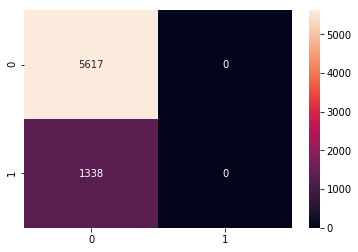

In [27]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score

# Initialize the classifier
clf = LogisticRegression(random_state=2018)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'C' : [0.001,0.01,0.1,1,10,100,1000], 'solver' : ['newton-cg', 'lbfgs', 'liblinear']}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


# Suggestions from Udacity
print('best_clf ： ', best_clf, '\n')

from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
pred = best_clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = '')

### Prediction


In [28]:
test_features.columns

Index(['order_id', 'group_id', 'source_1', 'source_2', 'unit', 'people_amount',
       'order_year', 'order_month', 'order_day', 'order_dayofyear',
       'order_weekday', 'go_time', 'back_time', 'go_route_num',
       'back_route_num', 'fly_time', 'sub_line', 'area', 'days', 'begin_date',
       'price', 'begin_year', 'begin_month', 'begin_day', 'begin_dayofyear',
       'begin_weekday', 'end_year', 'end_month', 'end_day', 'end_dayofyear',
       'end_weekday', 'date_diff_order_begin', ' deal_or_not'],
      dtype='object')

In [29]:
test_features = test_features.fillna(0)   ## TODO:  fillna考慮 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
test_features_X = test_features.drop(['order_id', 'group_id', 'begin_date', ' deal_or_not'], axis=1)
final_predictions = best_clf.predict(test_features_X)

## Modeling 2 : Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [31]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
rf_predictions = rf_model.predict(X_test)


Optimized Model
------
Final accuracy score on the testing data: 0.8076
Final precision score on the testing data: 0.5000
Final recall score on the testing data: 0.1555
Final F-score on the testing data: 0.3464


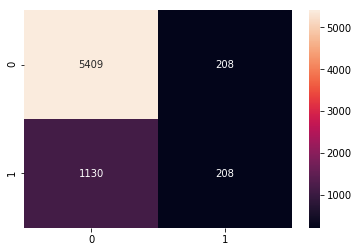

In [33]:
# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, rf_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, rf_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, rf_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, rf_predictions, beta = 0.5)))



from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
pred = rf_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = '')

In [34]:
rf_final_predictions = rf_model.predict(test_features_X)

In [35]:
rf_final_predictions[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

In [36]:
# make the dataset output meet the format

In [37]:
rf_final_predictions.size

99895

In [38]:
len(test_features['order_id'])

99895

In [39]:
rf_results = pd.DataFrame(data={'order_id': test_features['order_id'], 'deal_or_not' : rf_final_predictions})

In [40]:
rf_results.to_csv('rf_results.csv', index=False)

## Model : hyper parameter + Random Forest

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n


Optimized Model
------
Final accuracy score on the testing data: 0.8076
Final precision score on the testing data: 0.0000
Final recall score on the testing data: 0.0000
Final F-score on the testing data: 0.0000
best_clf ：  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2018, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False) 



/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


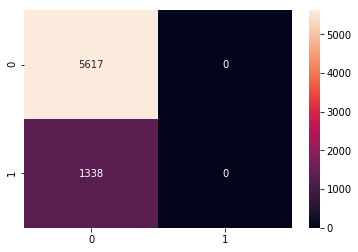

In [41]:
# Initialize the classifier
rf_hyper = RandomForestClassifier(random_state=0)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'max_depth' : [0.2, 0.4, 0.8],  'min_samples_split' : [0.2, 0.4, 0.8], 'min_samples_leaf' : list(range(1, 5)), 'n_jobs' : list(range(1, 10))}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_rf = GridSearchCV(rf_hyper, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_rf_fit = grid_rf.fit(X_train, y_train)

# Get the estimator
best_rf = grid_rf_fit.best_estimator_

# Make predictions
best_predictions = best_rf.predict(X_test)

# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


# Suggestions from Udacity
print('best_clf ： ', best_clf, '\n')

from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
pred = best_rf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = '')


Optimized Model
------
Final accuracy score on the testing data: 0.8076
Final precision score on the testing data: 0.0000
Final recall score on the testing data: 0.0000
Final F-score on the testing data: 0.0000


/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


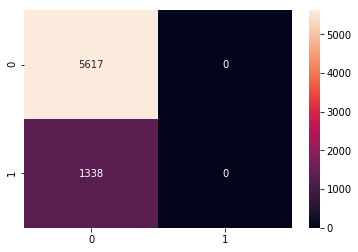

In [42]:
# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, pred)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, pred)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, pred)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, pred, beta = 0.5)))



from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = '')

> 小結： TODO   hyperparameter 可能中間哪裡寫錯了  結果並沒有比較好 TT   未來有空再來Debug.... 先來搞XgBoost

## Model: XgBoost

In [2]:
import xgboost as xgb

In [ ]:
# dummy化
df_predictors_dummy = pd.get_dummies(df_predictors)


# seperate into train and test features
train_features_dummy = pd.merge(df_predictors_dummy, train_data, on='order_id', how='inner') 
test_features_dummy = pd.merge(df_predictors_dummy, test_data, on='order_id', how='inner')


# train features: drop nulls
train_features_dummy = train_features_dummy.dropna()  # TODO:  try to save more data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

train_features_y_dummy = train_features_dummy['deal_or_not']
train_features_X_dummy = train_features_dummy.drop(['order_id', 'group_id', 'begin_date', 'deal_or_not'], axis=1)


# test features: fill nulls with 0 
test_features_X_dummy = test_features_dummy.fillna(0)   ## TODO:  fillna考慮 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
test_features_X_dummy = test_features_dummy.drop(['order_id', 'group_id', 'begin_date', ' deal_or_not'], axis=1)


X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(train_features_dummy, 
                                                    train_features_y_dummy, 
                                                    test_size = 0.33, 
                                                    random_state = 0)


In [87]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_dummy, y_train_dummy)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [88]:
xgb_predictions = xgb_model.predict(X_test_dummy)

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Optimized Model
------
Final accuracy score on the testing data: 0.8263
Final precision score on the testing data: 0.9514
Final recall score on the testing data: 0.1024
Final F-score on the testing data: 0.3579


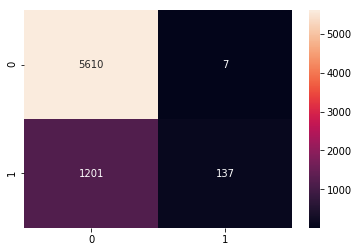

In [91]:
# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_dummy, xgb_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test_dummy, xgb_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test_dummy, xgb_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test_dummy, xgb_predictions, beta = 0.5)))



from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(y_test_dummy, xgb_predictions), annot = True, fmt = '')

In [96]:
xgb_results = pd.DataFrame(data={'order_id': test_features['order_id'], 'deal_or_not' : xgb_model.predict(test_features_X_dummy)})
xgb_results.to_csv('xgb_results.csv', index=False)

ValueError: feature_names mismatch: ['unit', 'people_amount', 'order_year', 'order_month', 'order_day', 'order_dayofyear', 'order_weekday', 'go_time', 'back_time', 'go_route_num', 'back_route_num', 'fly_time', 'days', 'price', 'begin_year', 'begin_month', 'begin_day', 'begin_dayofyear', 'begin_weekday', 'end_year', 'end_month', 'end_day', 'end_dayofyear', 'end_weekday', 'date_diff_order_begin', 'source_1_1', 'source_1_2', 'source_1_3', 'source_2_1', 'source_2_2', 'source_2_3', 'source_2_4', 'sub_line_10', 'sub_line_15', 'sub_line_18', 'sub_line_19', 'sub_line_20', 'sub_line_21', 'sub_line_22', 'sub_line_23', 'area_114', 'area_115', 'area_116', 'area_117', 'area_118', 'area_119', 'area_120', 'area_121', 'area_122', 'area_123', 'area_124', 'area_125', 'area_126', 'area_127', 'area_128', 'area_129', 'area_130', 'area_131', 'area_132', 'area_133', 'area_134', 'area_135', 'area_136', 'area_137', 'area_138', 'area_139', 'area_140', 'area_141'] ['unit', 'people_amount', 'order_year', 'order_month', 'order_day', 'order_dayofyear', 'order_weekday', 'go_time', 'back_time', 'go_route_num', 'back_route_num', 'fly_time', 'days', 'price', 'begin_year', 'begin_month', 'begin_day', 'begin_dayofyear', 'begin_weekday', 'end_year', 'end_month', 'end_day', 'end_dayofyear', 'end_weekday', 'date_diff_order_begin', 'source_1_1', 'source_1_2', 'source_1_3', 'source_2_1', 'source_2_2', 'source_2_3', 'source_2_4', 'sub_line_1', 'sub_line_10', 'sub_line_11', 'sub_line_12', 'sub_line_13', 'sub_line_14', 'sub_line_15', 'sub_line_16', 'sub_line_17', 'sub_line_18', 'sub_line_19', 'sub_line_2', 'sub_line_20', 'sub_line_21', 'sub_line_22', 'sub_line_23', 'sub_line_3', 'sub_line_4', 'sub_line_5', 'sub_line_6', 'sub_line_7', 'sub_line_8', 'sub_line_9', 'area_1', 'area_10', 'area_100', 'area_101', 'area_102', 'area_103', 'area_104', 'area_105', 'area_106', 'area_107', 'area_108', 'area_109', 'area_11', 'area_110', 'area_111', 'area_113', 'area_114', 'area_115', 'area_116', 'area_117', 'area_118', 'area_119', 'area_120', 'area_122', 'area_123', 'area_124', 'area_126', 'area_127', 'area_128', 'area_129', 'area_13', 'area_130', 'area_132', 'area_133', 'area_134', 'area_135', 'area_136', 'area_137', 'area_138', 'area_139', 'area_14', 'area_140', 'area_141', 'area_142', 'area_143', 'area_144', 'area_145', 'area_146', 'area_147', 'area_149', 'area_150', 'area_151', 'area_152', 'area_153', 'area_155', 'area_156', 'area_157', 'area_17', 'area_18', 'area_19', 'area_2', 'area_20', 'area_21', 'area_22', 'area_23', 'area_24', 'area_25', 'area_27', 'area_28', 'area_29', 'area_30', 'area_31', 'area_32', 'area_33', 'area_34', 'area_35', 'area_36', 'area_38', 'area_39', 'area_4', 'area_40', 'area_41', 'area_42', 'area_44', 'area_45', 'area_47', 'area_48', 'area_49', 'area_5', 'area_50', 'area_51', 'area_52', 'area_53', 'area_54', 'area_57', 'area_59', 'area_6', 'area_60', 'area_61', 'area_62', 'area_63', 'area_64', 'area_65', 'area_66', 'area_67', 'area_68', 'area_69', 'area_7', 'area_70', 'area_71', 'area_72', 'area_73', 'area_74', 'area_8', 'area_81', 'area_82', 'area_83', 'area_84', 'area_85', 'area_86', 'area_87', 'area_88', 'area_89', 'area_9', 'area_90', 'area_91', 'area_92', 'area_93', 'area_94', 'area_95', 'area_96', 'area_97', 'area_98', 'area_99']
expected area_131, area_125, area_121 in input data
training data did not have the following fields: area_7, area_57, area_24, area_35, sub_line_6, area_74, area_4, area_151, area_89, sub_line_12, area_6, area_69, area_145, sub_line_4, area_1, area_23, sub_line_13, area_90, area_5, area_59, area_110, area_18, area_39, area_94, area_95, area_99, area_144, area_70, area_102, area_156, area_2, area_82, area_103, area_62, area_40, area_20, area_93, area_13, area_36, area_33, area_22, area_41, area_81, area_42, area_10, sub_line_8, area_149, area_88, area_84, sub_line_9, area_65, area_72, area_32, area_113, area_47, area_34, area_50, area_153, area_105, area_53, area_111, area_100, area_48, area_64, area_106, area_155, sub_line_14, sub_line_11, sub_line_7, area_19, area_61, area_92, area_97, area_87, sub_line_17, sub_line_16, area_9, area_31, area_150, area_54, area_28, area_142, area_104, area_17, area_44, area_108, area_73, area_109, area_67, sub_line_3, area_83, area_52, area_25, area_49, area_60, area_143, area_91, area_107, area_101, area_66, area_68, area_146, sub_line_2, area_157, area_27, area_29, area_30, area_45, area_11, sub_line_5, area_14, area_51, area_96, area_63, area_86, area_38, sub_line_1, area_98, area_85, area_152, area_21, area_71, area_8, area_147